# Unit-Line Sampling

The following code was used to generate data for the unit-line experiment. 
The data was then post-processed for visualization in the figures folder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import gaussian_kde

from sklearn.neighbors import KernelDensity
import pandas as pd

In [2]:
@njit
def runif(low,up):
    diff = up-low
    return np.random.rand(1) * diff + low

@njit
def gw_sample_eq(n,low,up,w,iters):
    samples = np.zeros((n,iters)) #, dtype=np.float)
    x = 0.
    x_temp = 0.
    found = False
    for k in range(iters):
        x = runif(low,up)
        for j in range(n):
            found = False
            while not found:
                x_temp = sample(x,w)
                if x_temp <= up and x_temp >= low:
                    samples[j,k] = x_temp[0]
                    found = True
                    x = x_temp
    return samples

@njit
def gw_sample_ineq(n,low,up,w,iters):
    samples = np.zeros((n,iters)) #, dtype=np.float)
    x = 0.
    x_temp = 0.
    low_arr = np.zeros(1)
    low_arr[0] = low
    up_arr = np.zeros(1)
    up_arr[0] = up
    for k in range(iters):
        x = runif(low,up)
        for j in range(n):
            x_temp = sample(x,w)
            if x_temp > up:
                x_temp = up_arr
            elif x_temp < low:
                x_temp = low_arr
            samples[j,k] = x_temp[0]
            x = x_temp
    return samples



@njit
def sample(x,w):
    return runif(low=x-w/2,up=x+w/2)

In [3]:
def expected_pdf(samples, low, up, n, bw, method="sklearn"):
    n_samples, n_iters = samples.shape
    dx = np.linspace(low, up, n)
    y = np.zeros((len(dx),n_iter))
    for i in range(n_iters):
        if method == "sklearn":
            kernel = KernelDensity(kernel='epanechnikov', bandwidth=bw).fit(samples[:,i].reshape(1,n_samples).T)
            y[:,i] = np.exp(kernel.score_samples(dx.reshape(1,-1).T))
        else: 
            kernel = gaussian_kde(samples[:,i].reshape(1,n_samples), bw_method=bw)
            y[:,i] = kernel.evaluate(dx.T)
    y = np.mean(y,axis=1)
    return y, dx


In [4]:
def plot_multiple(pdf_dict, label, save):
    fig = plt.figure(figsize=(10,10))
    for k,v in pdf_dict.items():
        plt.plot(v,label=k)
    plt.title(f"{label}")
    plt.grid()
    plt.legend()
    if save:
        plt.savefig(f"{label}.jpg")
    plt.show()
    

In [63]:
%%timeit
gw_sample_ineq(100,0.,1.,0.2,10)

468 µs ± 5.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [64]:
%%timeit
gw_sample_eq(100,0.,1.,0.2,10)

504 µs ± 786 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


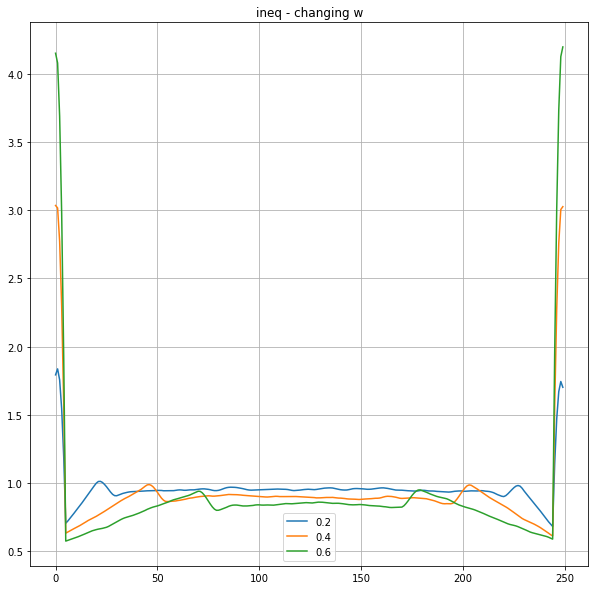

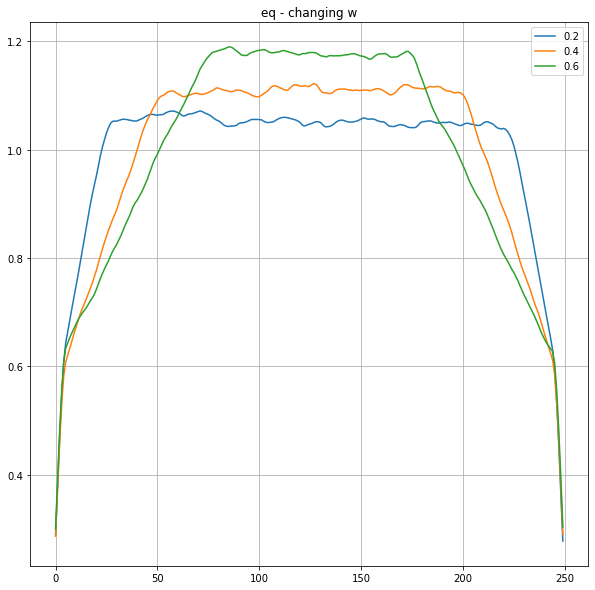

In [7]:
# rising w
#n_samples = 10000
#n_iter = 100
n_samples = 1000000
n_iter = 1

ws = [0.2,0.4,0.6]
low = 0.
up = 1.
ndx=250
bw=0.02


pdfs_ineq = {}
pdfs_eq = {}

for w in ws:
    samples = gw_sample_ineq(n_samples, low, up, w, n_iter)
    pdfs_ineq[w],xs = expected_pdf(samples,low,up,ndx,bw)
    samples = gw_sample_eq(n_samples, low, up, w, n_iter)
    pdfs_eq[w],xs = expected_pdf(samples,low,up,ndx,bw)

plot_multiple(pdfs_ineq,"ineq - changing w",True)
plot_multiple(pdfs_eq,"eq - changing w",True)



pdfs_ineq["x"] = xs
pdfs_eq["x"] = xs
pd.DataFrame(pdfs_ineq).to_csv("grid_walk_projection_continous_unit_line_w.csv")
pd.DataFrame(pdfs_eq).to_csv("grid_walk_rejection_continous_unit_line_w.csv")

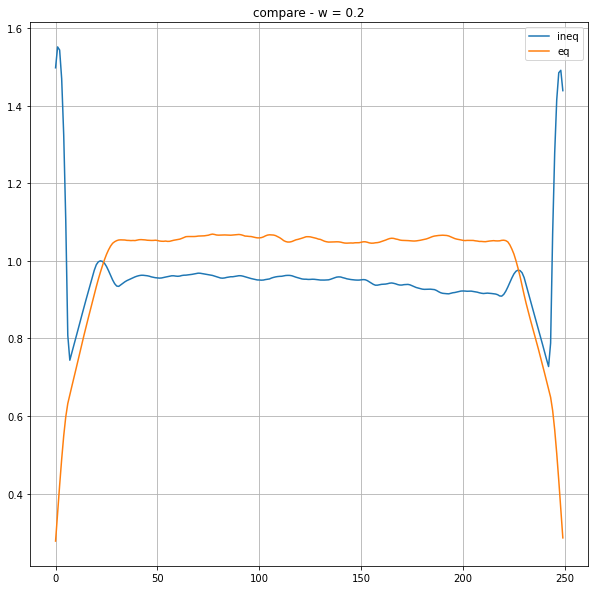

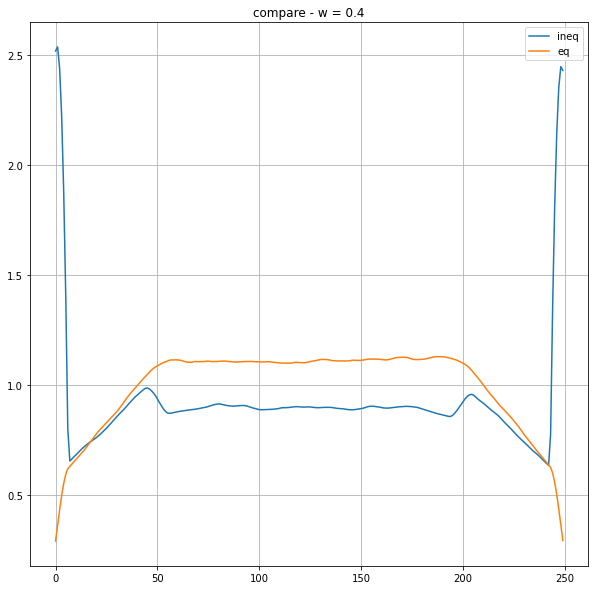

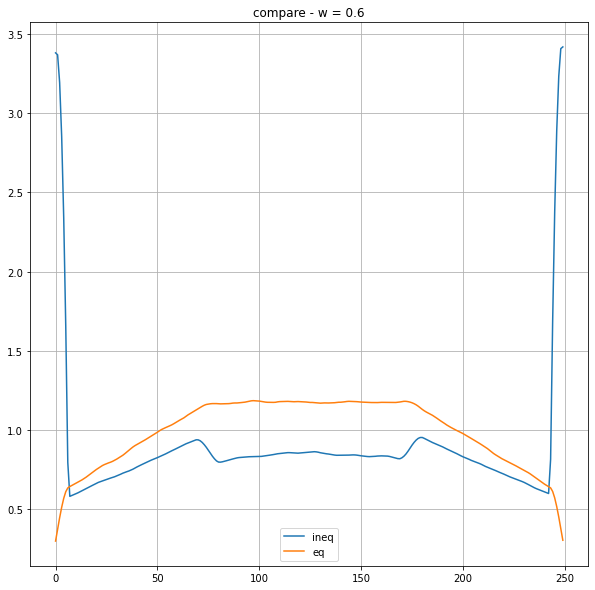

In [47]:
for k in pdfs_ineq.keys():
    pdf_pair = {}
    pdf_pair["ineq"] = pdfs_ineq[k]
    pdf_pair["eq"] = pdfs_eq[k]
    plot_multiple(pdf_pair,f"compare - w = {k}", True)
    

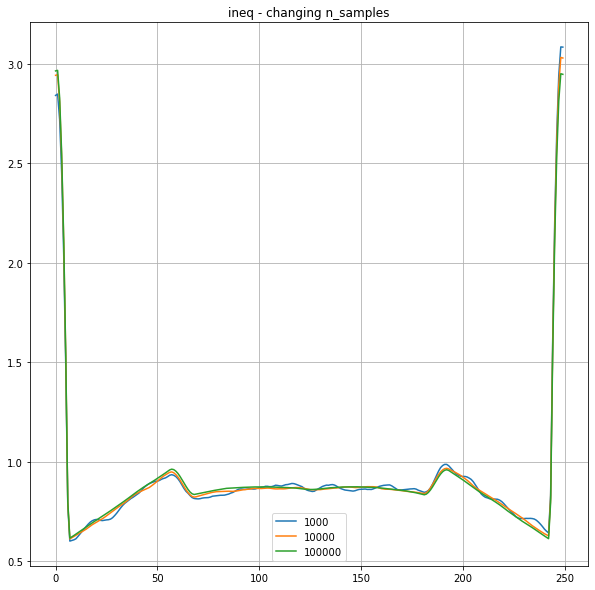

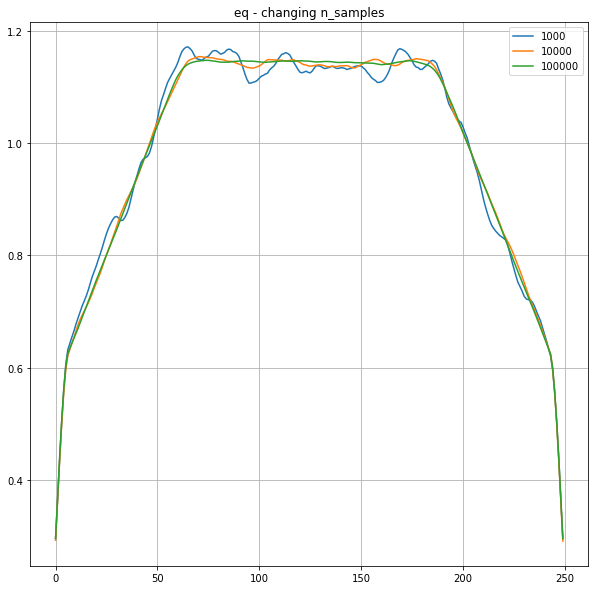

In [49]:
# rising n_samples
n_samples = [1000,10000,100000]
n_iter = 100
w = 0.5
low = 0.
up = 1.
ndx=250
bw=0.025


pdfs_ineq = {}
pdfs_eq = {}

for n in n_samples:
    samples = gw_sample_ineq(n, low, up, w, n_iter)
    pdfs_ineq[n] = expected_pdf(samples,low,up,ndx,bw)
    samples = gw_sample_eq(n, low, up, w, n_iter)
    pdfs_eq[n] = expected_pdf(samples,low,up,ndx,bw)

plot_multiple(pdfs_ineq,"ineq - changing n_samples", True)
plot_multiple(pdfs_eq,"eq - changing n_samples", True)
    

In [8]:
@njit
def nearest_neighbor(x, samples):
    current = 0
    min_dist = np.Inf
    for i in range(len(samples)):
        dist = (x - samples[i]) * (x - samples[i])
        if dist < min_dist:
            current = samples[i]
            min_dist = dist
    return current
        
@njit
def rrt(low, up, alpha, n, b_low, b_up, eqonly=True):
    root = runif(low,up)
    samples = np.zeros(n)
    samples[0] = root[0]
    found = False
    x_near = 0.
    for i in range(1,n):
        found = False
        while not found:
            x = runif(b_low, b_up)
            x_near = nearest_neighbor(x[0], samples[:i])
            x_new = x_near + np.sign(x - x_near)*alpha
            if x_new >= low and x_new <= up:
                samples[i] = x_new[0]
                found = True
            elif not eqonly:
                if x_new < low:
                    samples[i] = low
                    found =  True
                else:
                    samples[i] = up
                    found =  True
    return samples

@njit
def rrt_multiple(low,up,alpha,n,b_low,b_up,eq_only=True,iters=10):
    samples = np.zeros((n,iters))
    for i in range(iters):
        samples[:,i] = rrt(low,up,alpha,n,b_low,b_up,eq_only)
    return samples

In [9]:
# rrt rising 
bounds = [0.3,0.5,0.7]
n_samples = 1000000
ns = [1000, 2000, 5000]
alpha = 0.0005
alphas = [alpha,alpha*2,alpha*3,alpha*4,alpha*5]
pdfs_rrt_eq = {}
pdfs_rrt_ineq = {}
#pdfs_rrt_ineq_n = {}
for b in bounds:
    samples = rrt_multiple(low,up,alpha,n_samples, 0-b,1+b,False,n_iter)
    pdfs_rrt_ineq[b],xs = expected_pdf(samples,low,up,ndx,bw)

for b in bounds:
    samples = rrt_multiple(low,up,alpha,n_samples, 0-b,1+b,True,n_iter)
    pdfs_rrt_eq[b],xs = expected_pdf(samples,low,up,ndx,bw)
    
    
#for a in alphas:
#    samples = rrt_multiple(low,up,a,n_samples, bounds[2]*-1,bounds[2]+1,True,n_iter)
#    pdfs_rrt_eq[a],xs = expected_pdf(samples,low,up,ndx,bw)

#for ni in ns:
#    samples = rrt_multiple(low,up,a,ni, bounds[-1]*-1,bounds[-1]+1,False,n_iter)
#    pdfs_rrt_ineq_n[ni],xs = expected_pdf(samples,low,up,ndx,bw)
    
    
#plot_multiple(pdfs_rrt_eq,"eq - changing alpha",True)
plot_multiple(pdfs_rrt_ineq,"ineq - changing bounds",True)
pdfs_rrt_ineq["x"] = xs
pd.DataFrame(pdfs_rrt_ineq).to_csv("rrt_projection_continous_unit_line_b.csv")
plot_multiple(pdfs_rrt_eq,"eq - changing bounds",True)
pdfs_rrt_eq["x"] = xs
pd.DataFrame(pdfs_rrt_eq).to_csv("rrt_rejection_continous_unit_line_b.csv")

#plot_multiple(pdfs_rrt_ineq_n,"ineq - changing n_samples",True)


KeyboardInterrupt: 

In [53]:
n = [1000,10000,100000] 
low = 0
up = 1

#ws = np.arange(0.1,0.5,0.1)
ws = [0.4]
eq = {}
ineq = {}

for ni in n:
    samples = np.zeros(int(ni)*len(ws)*100).reshape(int(ni),len(ws),100) 
    for k in range(100):
        for i,w in enumerate(ws):
            x = np.random.uniform(low,up)
            for j in range(ni):
                found = False
                while not found:
                    x_temp = sample(x,w)
                    if x_temp <= up and x_temp >= low:
                        samples[j,i,k] = x_temp
                        found = True
                        x = x_temp      
    #plotting(samples, True,"eq")
    eq[ni] = kernel_mean(samples,True,"eq")
    samples2 = np.zeros(int(ni)*len(ws)*100).reshape(int(ni),len(ws),100)
    for k in range(100):
        for i,w in enumerate(ws):
            x = np.random.uniform(low,up)
            for j in range(ni):
                x_temp = sample(x,w)
                if x_temp < low:
                    samples2[j,i,k] = low    
                    x = low
                elif x_temp > up:
                    samples2[j,i,k] = up
                    x = up
                else:
                    samples2[j,i,k] = x_temp
                    x = x_temp
    ineq[ni] = kernel_mean(samples2,True,"eq")

    #plotting(samples2,True,"ineq")
